### Sentiment Analysis of COVID-19 Vaccine Tweets
Gourav Verma<br>
DSC-680 T302, Spring 21<br>
Prof Fadi Alsaleem

In [1]:
# Import important libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as pl
import re
import datetime

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
#import spacy
import pickle

import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\goura\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read COVID-19 Vaccine Tweets dataset

In [2]:
# Read the data
#raw_df = pd.read_csv("vaccination_all_tweets.csv")

raw_df = pd.read_csv("vaccine_all_en_noretweets.csv")
raw_df.head()

,index,created_at,text
0,3,Sat Oct 31 23:59:58 +0000 2020,@realDonaldTrump Trump was right again! Hydrox...
1,10,Sun Nov 01 00:00:02 +0000 2020,@G_Shimer @BudGothmog44 Remdesivir has been si...
2,12,Sun Nov 01 00:00:04 +0000 2020,The 'silver bullet' for coronavirus might one ...
3,13,Sun Nov 01 00:00:05 +0000 2020,@Bitflick @btcdgb @celtasia @PeterMcCormack Pe...
4,18,Sun Nov 01 00:00:06 +0000 2020,Why on Earth would the American people be bett...


In [4]:
raw_df = raw_df.drop('index', axis=1)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704661 entries, 0 to 6704660
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   created_at  object
 1   text        object
dtypes: object(2)
memory usage: 102.3+ MB


In [6]:
df_sample = raw_df.sample(frac=0.1, random_state=1)

In [7]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670466 entries, 3149017 to 4827673
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  670466 non-null  object
 1   text        670466 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


## Sentiment Analysis

### Read train dataset for tweets
Downloaded from: https://www.kaggle.com/c/tweet-sentiment-extraction <br>
We will use if only to train our model. Not for sentiment analysis

In [8]:
tweet_train = pd.read_csv("train.csv")

In [9]:
tweet_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<AxesSubplot:>

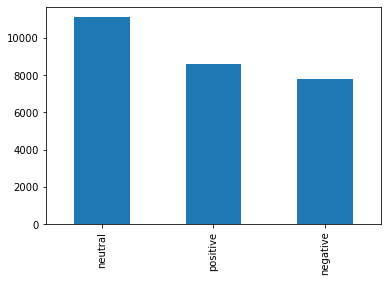

In [10]:
# Bar plot of sentiments
fig, ax = plt.subplots()
tweet_train['sentiment'].value_counts().plot(ax=ax, kind='bar')

In [11]:
# Remove unnecessary columns
tweet_train = tweet_train.drop(['textID', 'text'], axis=1)
tweet_train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [12]:
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27480 non-null  object
 1   sentiment      27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [13]:
# Drop null rows with null
tweet_train = tweet_train.dropna()
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27480 non-null  object
 1   sentiment      27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


### Data Cleaning

In [14]:
def data_cleaning(text):
    """
    Function to perform below tasks:
    - Remove URL
    - Remove emails
    - Remove newline characters
    - Remove single quotes
    """
    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    textc = url.sub(r'', text)
    
    # Remove Emails
    textc = re.sub('\S*@\S*\s?', '', textc)
    
    # Remove newline
    textc = re.sub('\s+', ' ', textc)
    
    # Remove single quotes
    textc = re.sub("\'", "", textc)
    
    return textc

In [15]:
text_list=[]

# Split selected_text to list
df_list = tweet_train['selected_text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

[' - some shameless plugging for the best Rangers forum on earth',
 'fun',
 'Soooo high',
 'Both of you',
 'Wow... u just became cooler.',
 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'like',
 'DANGERously',
 'lost',
 'test test from the LG enV2']

In [16]:
def data_word(sent):
    """
    Function to split sentences to words 
    """
    for s in sent:
        yield(gensim.utils.simple_preprocess(str(s), deacc=True))
    
    return

text_word = list(data_word(text_list))

print(text_word[5:15])

[['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler'], ['as', 'much', 'as', 'love', 'to', 'be', 'hopeful', 'reckon', 'the', 'chances', 'are', 'minimal', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'from', 'the', 'lg', 'env']]


### Detokenization

In [17]:
def detok(text_word):
    return 

text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[5:15])

['some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow just became cooler', 'as much as love to be hopeful reckon the chances are minimal never gonna get my cake and stuff', 'like', 'dangerously', 'lost', 'test test from the lg env']


In [18]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Label Encoding

In [19]:
# Convert categorical values to float

label = np.array(tweet_train['sentiment'])
num = []
for i in range(len(label)):
    if label[i] == 'neutral':
        num.append(0)
    if label[i] == 'negative':
        num.append(1)
    if label[i] == 'positive':
        num.append(2)

num = np.array(num)

label = tf.keras.utils.to_categorical(num, 3, dtype="float32")
label

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

### Sequencing and Splitting

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [21]:
max_words = 5000
max_len = 200

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(text_ar)
seq = tokenize.texts_to_sequences(text_ar)
tweet = pad_sequences(seq, maxlen=max_len)
print(tweet)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


### Model Building

In [22]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(tweet,label, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6870 20610 6870


#### Single LSTM

In [23]:
mod1 = Sequential()
mod1.add(layers.Embedding(max_words, 20))
mod1.add(layers.LSTM(15, dropout=0.5))
mod1.add(layers.Dense(3, activation='softmax'))

mod1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt1 = ModelCheckpoint('mod1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod1.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt1])

645/645 [==============================] - 39s 57ms/step - loss: 0.8987 - accuracy: 0.6008 - val_loss: 0.6206 - val_accuracy: 0.7504

Epoch 00001: val_accuracy improved from -inf to 0.75036, saving model to mod1.hdf5


In [24]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2160      
_________________________________________________________________
dense (Dense)                (None, 3)                 48        
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________


#### Bidirectional LSTM

In [25]:
mod2 = Sequential()
mod2.add(layers.Embedding(max_words, 40, input_length=max_len))
mod2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
mod2.add(layers.Dense(3, activation='softmax'))
mod2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt2 = ModelCheckpoint('mod2.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod2.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt2])

645/645 [==============================] - 48s 71ms/step - loss: 0.8841 - accuracy: 0.5878 - val_loss: 0.6427 - val_accuracy: 0.7444

Epoch 00001: val_accuracy improved from -inf to 0.74440, saving model to mod2.hdf5


In [26]:
mod2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________


#### 1D CNN

In [27]:
mod3 = Sequential()
mod3.add(layers.Embedding(max_words, 40, input_length=max_len))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.MaxPooling1D(5))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.GlobalMaxPooling1D())
mod3.add(layers.Dense(3, activation='softmax'))
mod3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

ckpt3 = ModelCheckpoint('mod3.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod3.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt3])

645/645 [==============================] - 7s 10ms/step - loss: 1.2771 - acc: 0.4676 - val_loss: 0.9023 - val_acc: 0.6102


In [28]:
mod3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
conv1d (Conv1D)              (None, 195, 20)           4820      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 20)            2420      
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 207,303
Trainable params: 207,303
Non-trainable params: 0
________________________________________________

**We can see that Bidirectional RNN model showed highest accuracy. Lets validate the model.**

In [29]:
predict=mod2.predict(X_test)

<AxesSubplot:>

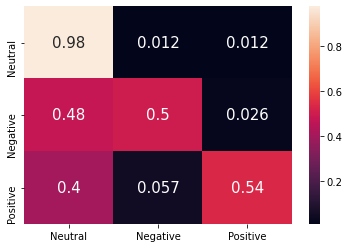

In [30]:
# Plot confusion matrix

c = confusion_matrix(y_test.argmax(axis=1), np.around(predict, decimals=0).argmax(axis=1))
matrix = pd.DataFrame(c, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive'])

matrix = matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(matrix, annot=True, annot_kws={"size": 15})


### Sentiment analysis on COVID-19 Tweet Dataset

In [31]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670466 entries, 3149017 to 4827673
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  670466 non-null  object
 1   text        670466 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [32]:
text_list=[]

# Split selected_text to list
df_list = df_sample['text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

['Would love if when you went to get a Covid vaccine, someone would be there. "Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic". Back of the line. Sorry.',
 'Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination ',
 'China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4. Click the below image for details. ',
 'via #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… ',
 'Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?',
 'raising awareness for covid-19 vaccines! ',
 'Same but I question my sanity if it takes another year. I just need a vaccine shot to feel at least a little sa

In [33]:
list(text_list[:10])

['Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC via ',
 '- #QOP is unfit to govern! Incredibly, after 4 years of ring kissing, enabling of Trumps American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE vote for Simulus!! ',
 'FDA just approved the covid vaccine too. while its in clinical trails. lol 2021, coming soon!',
 'Covid-vaccines',
 'Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo ',
 'Would love if when you went to get a Covid vaccine, someone would be there. "Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic". Back of the line. Sorry.',
 'Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination ',
 'China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4. Click the below image for detai

In [34]:
text_word = list(data_word(text_list))

print(text_word[0:10])

[['complaint', 'against', 'mogoeng', 'over', 'covid', 'vaccine', 'comment', 'escalated', 'to', 'jcc', 'via'], ['qop', 'is', 'unfit', 'to', 'govern', 'incredibly', 'after', 'years', 'of', 'ring', 'kissing', 'enabling', 'of', 'trumps', 'american', 'carnage', 'silence', 'during', 'his', 'deadly', 'covid', 'negligence', 'and', 'witnessing', 'vp', 'pence', 'and', 'dems', 'targeted', 'by', 'trump', 'for', 'execution', 'not', 'one', 'vote', 'for', 'simulus'], ['fda', 'just', 'approved', 'the', 'covid', 'vaccine', 'too', 'while', 'its', 'in', 'clinical', 'trails', 'lol', 'coming', 'soon'], ['covid', 'vaccines'], ['nigeria', 'main', 'priority', 'is', 'covid', 'vaccine', 'vp', 'osinbajo'], ['would', 'love', 'if', 'when', 'you', 'went', 'to', 'get', 'covid', 'vaccine', 'someone', 'would', 'be', 'there', 'welp', 'looks', 'like', 'on', 'october', 'you', 'said', 'on', 'facebook', 'that', 'it', 'was', 'all', 'hoax', 'and', 'the', 'vaccine', 'was', 'toxic', 'back', 'of', 'the', 'line', 'sorry'], ['pet

### Detokenization

In [35]:
text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[0:10])

['complaint against mogoeng over covid vaccine comment escalated to jcc via', 'qop is unfit to govern incredibly after years of ring kissing enabling of trumps american carnage silence during his deadly covid negligence and witnessing vp pence and dems targeted by trump for execution not one vote for simulus', 'fda just approved the covid vaccine too while its in clinical trails lol coming soon', 'covid vaccines', 'nigeria main priority is covid vaccine vp osinbajo', 'would love if when you went to get covid vaccine someone would be there welp looks like on october you said on facebook that it was all hoax and the vaccine was toxic back of the line sorry', 'petition prioritise teachers school and childcare staff for covid vaccination', 'china kept deceiving the world amp its own people that the virus is not human transferrable till jan while secretly started developing vaccines on jan click the below image for details', 'via health china prepares large scale rollout of coronavirus vacc

In [36]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Add an empty sentiment column to the dataset

In [37]:
df_sample["Sentiments"] = np.nan

In [60]:
df_sample.head(10)

,created_at,text,Sentiments
3149017,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,NaN
4248215,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",NaN
2567946,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",NaN
17874,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
314152,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral
2157029,Mon Dec 21 17:29:26 +0000 2020,"Would love if when you went to get a Covid vaccine, someone would be there. ""Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic"". Back of the line. Sorry.",NaN
2138787,Mon Dec 21 08:38:33 +0000 2020,"Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination https://t.co/imbtbl0hBd",NaN
702524,Tue Nov 24 04:52:53 +0000 2020,@amyyqin China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4.\nClick the below image for details. https://t.co/brGTqFsRJj,NaN
1214336,Sun Dec 06 08:41:36 +0000 2020,"via @PerilOfAfrica #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… https://t.co/SumX0SicnF https://t.co/v5RrtaYhlQ",NaN
4970892,Sun Feb 21 15:00:46 +0000 2021,Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?,NaN


In [64]:
df_sample = df_sample.reset_index(drop=True)

In [66]:
df_sample["text"].head(10)

0                                                                                                                                                                                                                    Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter
1    @JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO
2                                                                                                                                                                                                                              @thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!
3                  

In [63]:
text_list[:10]

['Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC via ',
 '- #QOP is unfit to govern! Incredibly, after 4 years of ring kissing, enabling of Trumps American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE vote for Simulus!! ',
 'FDA just approved the covid vaccine too. while its in clinical trails. lol 2021, coming soon!',
 'Covid-vaccines',
 'Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo ',
 'Would love if when you went to get a Covid vaccine, someone would be there. "Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic". Back of the line. Sorry.',
 'Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination ',
 'China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4. Click the below image for detai

In [67]:
len(text_list)

670466

### Apply best model (Bidirection RNN) to the dataset

In [73]:
sentiment = ['Neutral','Negative','Positive']
for l in range(len(text_list)):
    seq = tokenize.texts_to_sequences([text_list[l]])
    tweet = pad_sequences(seq, maxlen=max_len)
    df_sample["Sentiments"][l] = sentiment[np.around(mod2.predict(tweet), decimals=0).argmax(axis=1)[0]]
    if (l % 6704 == 0):
        perc = l/len(text_list) * 100
        f_perc = "{:.0f}".format(perc)
        print(f_perc,"%")

        
final_df = df_sample
df_sample.to_csv('df_sample.csv', index=False)

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


**Applying model to dataset takes long time, So saved final dataset to a .CSV file. I will be using this CSV file for further analysis..**

In [74]:
#final_df = df_sample
#df_sample.to_csv('df_sample.csv', index=False)

In [75]:
tweet_sent = pd.read_csv('df_sample.csv')

pd.set_option('display.max_colwidth', None)
tweet_sent[["text", "Sentiments"]].head(15)

,text,Sentiments
0,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,Neutral
1,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",Neutral
2,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",Neutral
3,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
4,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral
5,"Would love if when you went to get a Covid vaccine, someone would be there. ""Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic"". Back of the line. Sorry.",Neutral
6,"Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination https://t.co/imbtbl0hBd",Neutral
7,@amyyqin China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4.\nClick the below image for details. https://t.co/brGTqFsRJj,Neutral
8,"via @PerilOfAfrica #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… https://t.co/SumX0SicnF https://t.co/v5RrtaYhlQ",Neutral
9,Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?,Neutral


In [76]:
# Sentiment Counts
tweet_sent.groupby('Sentiments').nunique()

,created_at,text
Sentiments,,
Negative,3165,3142
Neutral,644539,661396
Positive,1703,1704


In [82]:
tweet_sent[tweet_sent["Sentiments"] == "Negative"].head(20)

,created_at,text,Sentiments
245,Thu Dec 24 21:51:44 +0000 2020,@CDCgov I'm not getting vaccine so..,Negative
334,Fri Mar 05 15:44:05 +0000 2021,Nigeria commences COVID-19 vaccination - https://t.co/yFa5YOrETD,Negative
477,Sun Feb 14 15:13:02 +0000 2021,Covid: Claims vaccinations harm fertility unfounded https://t.co/Wl6MYlD8tI,Negative
604,Wed Nov 18 18:04:41 +0000 2020,2k tournament https://t.co/iznyvkyNwm,Negative
744,Wed Mar 03 18:05:54 +0000 2021,Petition: Do not rollout Covid-19 vaccine passports https://t.co/HlKiBL9Bwy,Negative
859,Mon Feb 08 10:34:16 +0000 2021,Disability Partnership Calderdale newsletter 05 February 2021\n@disabilitypartnershipcalderdale @coronavirus @vaccine @consultations @usefulinfo\n#disabilitypartnershipcalderdale #coronavirus #vaccine #consultations #usefulinfo https://t.co/CwsL6AJVnz,Negative
1386,Tue Mar 09 20:38:11 +0000 2021,PHOTOS: Osun receives COVID-19 vaccine https://t.co/7hHYvNT7Kp,Negative
1474,Wed Feb 10 15:24:10 +0000 2021,Ist dose covid vaccine https://t.co/9KbcJG4TJO,Negative
1637,Thu Mar 11 10:06:42 +0000 2021,"Taraba receive 56,250 AstraZeneca COVID-19 vaccine https://t.co/LemcaKjHW1",Negative
1847,Tue Nov 17 12:42:06 +0000 2020,Trump's transition sabotage threatens vaccine rollout #SmartNews https://t.co/xmv9uPb8V1,Negative


### Taking 2nd 10% sample  ====> Ignore below code....!!!!

In [83]:
df_sample2 = raw_df.sample(frac=0.1, random_state=1)

In [84]:
df_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670466 entries, 3149017 to 4827673
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  670466 non-null  object
 1   text        670466 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [86]:
df_sample2["Sentiments"] = np.nan

In [90]:
df_sample2.head()

,created_at,text,Sentiments
3149017,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,NaN
4248215,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",NaN
2567946,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",NaN
17874,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,NaN
314152,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,NaN


In [87]:
text_list2=[]

# Split selected_text to list
df_list2 = df_sample2['text'].values.tolist()


In [89]:
df_list2[1]

"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO"

In [91]:
# Clean the texts
for t in range(len(df_list)):
    text_list2.append(data_cleaning(df_list2[t]))

list(text_list2[0:10])

['Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC via ',
 '- #QOP is unfit to govern! Incredibly, after 4 years of ring kissing, enabling of Trumps American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE vote for Simulus!! ',
 'FDA just approved the covid vaccine too. while its in clinical trails. lol 2021, coming soon!',
 'Covid-vaccines',
 'Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo ',
 'Would love if when you went to get a Covid vaccine, someone would be there. "Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic". Back of the line. Sorry.',
 'Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination ',
 'China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4. Click the below image for detai

In [92]:
df_sample2 = df_sample2.reset_index(drop=True)
df_sample2.head()

,created_at,text,Sentiments
0,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,NaN
1,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",NaN
2,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",NaN
3,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,NaN
4,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,NaN


In [93]:
len(text_list2)

670466

In [94]:
sentiment = ['Neutral','Negative','Positive']
for l in range(len(text_list2)):
    seq = tokenize.texts_to_sequences([text_list2[l]])
    tweet = pad_sequences(seq, maxlen=max_len)
    df_sample2["Sentiments"][l] = sentiment[np.around(mod2.predict(tweet), decimals=0).argmax(axis=1)[0]]
    if (l % 6704 == 0):
        perc = l/len(text_list2) * 100
        f_perc = "{:.0f}".format(perc)
        print(f_perc,"%")

        
final_df2 = df_sample2
df_sample2.to_csv('df_sample2.csv', index=False)

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


In [95]:
final_df2 = df_sample2
df_sample2.to_csv('df_sample2.csv', index=False)

tweet_sent2 = pd.read_csv('df_sample2.csv')

pd.set_option('display.max_colwidth', None)
tweet_sent2[["text", "Sentiments"]].head(15)

,text,Sentiments
0,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,Neutral
1,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",Neutral
2,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",Neutral
3,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
4,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral
5,"Would love if when you went to get a Covid vaccine, someone would be there. ""Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic"". Back of the line. Sorry.",Neutral
6,"Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination https://t.co/imbtbl0hBd",Neutral
7,@amyyqin China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4.\nClick the below image for details. https://t.co/brGTqFsRJj,Neutral
8,"via @PerilOfAfrica #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… https://t.co/SumX0SicnF https://t.co/v5RrtaYhlQ",Neutral
9,Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?,Neutral


In [96]:
# Sentiment Counts
tweet_sent2.groupby('Sentiments').nunique()

,created_at,text
Sentiments,,
Negative,3165,3142
Neutral,644539,661396
Positive,1703,1704


In [97]:
tweet_sent2[tweet_sent2["Sentiments"] == "Negative"].head(20)

,created_at,text,Sentiments
245,Thu Dec 24 21:51:44 +0000 2020,@CDCgov I'm not getting vaccine so..,Negative
334,Fri Mar 05 15:44:05 +0000 2021,Nigeria commences COVID-19 vaccination - https://t.co/yFa5YOrETD,Negative
477,Sun Feb 14 15:13:02 +0000 2021,Covid: Claims vaccinations harm fertility unfounded https://t.co/Wl6MYlD8tI,Negative
604,Wed Nov 18 18:04:41 +0000 2020,2k tournament https://t.co/iznyvkyNwm,Negative
744,Wed Mar 03 18:05:54 +0000 2021,Petition: Do not rollout Covid-19 vaccine passports https://t.co/HlKiBL9Bwy,Negative
859,Mon Feb 08 10:34:16 +0000 2021,Disability Partnership Calderdale newsletter 05 February 2021\n@disabilitypartnershipcalderdale @coronavirus @vaccine @consultations @usefulinfo\n#disabilitypartnershipcalderdale #coronavirus #vaccine #consultations #usefulinfo https://t.co/CwsL6AJVnz,Negative
1386,Tue Mar 09 20:38:11 +0000 2021,PHOTOS: Osun receives COVID-19 vaccine https://t.co/7hHYvNT7Kp,Negative
1474,Wed Feb 10 15:24:10 +0000 2021,Ist dose covid vaccine https://t.co/9KbcJG4TJO,Negative
1637,Thu Mar 11 10:06:42 +0000 2021,"Taraba receive 56,250 AstraZeneca COVID-19 vaccine https://t.co/LemcaKjHW1",Negative
1847,Tue Nov 17 12:42:06 +0000 2020,Trump's transition sabotage threatens vaccine rollout #SmartNews https://t.co/xmv9uPb8V1,Negative
